# Import Package

In [5]:
import pandas as pd
import numpy as np
from numpy.linalg import inv, det
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Configuration Variable

In [6]:
config = {
    "seed" : 714
}

# Input and data slice

In [7]:
read = pd.read_csv("./Wine.csv")
grouped = read.groupby(read['target'])
test_data = pd.DataFrame()

# Random select test data
for i in read.iloc[:, 0].unique():
    tmp = grouped.get_group(i).sample(n = 20, random_state = config['seed'])
    test_data = pd.concat([test_data, tmp])

# Remove test data from input
train_data = read.drop(test_data.index)

# Shuffle the data
train_data = train_data.sample(frac = 1, random_state = config['seed'], ignore_index = 1)
test_data = test_data.sample(frac = 1, random_state = config['seed'], ignore_index = 1)

train_data.to_csv('./train.csv', index = False)
test_data.to_csv('./test.csv', index = False)

# Split train, test data to x, y
x_train = train_data.iloc[:, 1:].values
y_train = train_data.iloc[:, 0].values
x_test = test_data.iloc[:, 1:].values
y_test = test_data.iloc[:, 0].values

In [8]:
read

,target,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,0,13.01,3.66,2.21,16.53,98.87,2.46,2.34,0.28,1.49,3.69,0.75,2.79,588.86
1,0,13.13,1.14,2.32,18.75,108.51,2.63,2.26,0.13,2.15,5.03,0.86,2.66,954.80
2,0,12.57,1.06,1.88,10.41,83.50,2.35,2.68,0.10,2.57,5.82,0.98,2.49,962.49
3,0,13.08,0.79,2.32,11.70,86.91,2.63,2.57,0.05,1.14,3.14,0.65,2.86,784.26
4,0,14.04,2.12,2.60,17.51,120.60,2.58,2.48,0.31,1.23,4.98,1.05,3.56,1286.11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
478,2,13.65,5.57,2.43,20.25,93.94,1.63,0.54,0.51,1.02,7.53,0.62,1.69,716.70
479,2,13.22,4.97,2.28,18.47,86.31,1.30,0.00,0.44,0.71,6.29,0.50,1.31,548.39
480,2,12.15,0.38,2.08,15.10,109.58,0.97,0.38,0.10,0.44,2.08,0.56,0.67,356.25
481,2,13.34,1.48,2.59,21.93,86.55,2.49,0.93,0.50,2.19,11.35,0.53,1.66,565.98


# Evaluate the posterior probabilities

### Caculate some of parameter
- mean
- covariance matrix 
- etc.

In [9]:
num_of_feature = x_train.shape[1]
num_of_classes = len(train_data.iloc[:, 0].unique())

mean = np.zeros((num_of_classes, num_of_feature))
cov = np.zeros((num_of_classes, num_of_feature, num_of_feature))
prior = np.zeros(num_of_classes)

# Caculate parameter for likelhood & Prior
for i in range(num_of_classes):
    # Extract subset of current class
    x_subset = x_train[y_train == i]
    # Mean of class
    mean[i] = np.mean(x_subset, axis = 0)
    # Covariance matrix of class
    cov[i] = np.cov(x_subset.transpose())
    # Prior of class
    prior[i] = len(x_subset) / len(x_train)

# Precision matrix of each class
pre = inv(cov)
# Determinant of covariance matrix of each class
det_cov = det(cov)

print(prior)

[0.36643026 0.43735225 0.19621749]


### Predict (MAP)
Calculate the posterior of test case with different class parameter.

Choose the maximum as the result and compare with label to get accuracy.

In [35]:
y_pred = np.zeros(x_test.shape[0])

for i, x in enumerate(x_test):
    # Square of Mahalanobis distance
    Mah_dis = np.zeros(num_of_classes)
    for c in range(num_of_classes):
        tmp = (x - mean[c])[:, np.newaxis]
        Mah_dis[c] = np.transpose(tmp).dot(pre[c]).dot(tmp)
    
    # Propotion of posterior
    posterior = np.log(prior) - np.log(det_cov) / 2 - Mah_dis / 2
    # Choose maximum posterior as prediction
    y_pred[i] = np.argmax(posterior)

# Compute the accuracy
num_of_corr = np.count_nonzero([np.array(y_pred == y_test)])
accuracy = num_of_corr / len(y_pred)

In [36]:
print(f"Random state: {config['seed']}")
print(f"Accuracy: {accuracy * 100}%")

Random state: 714
Accuracy: 98.33333333333333%


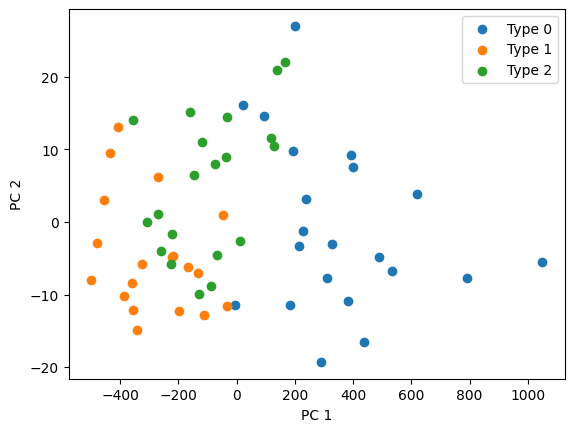

In [37]:
# Reduced dimension of test data for visulization
pca = PCA(n_components = 2)
x_pca = pca.fit_transform(x_test)

# Plot the result of prediction
type = ['Type 0', 'Type 1', 'Type 2']
for i in range(num_of_classes):
    plt.scatter(x_pca[y_pred == i, 0], x_pca[y_pred == i, 1], label = type[i])
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.legend()
plt.show()